<a href="https://colab.research.google.com/github/ZawarKhan/semeval19_task3/blob/master/hate_speech_with_bert_and_cnn_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [2]:
import logging
import time
from platform import python_version

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
!pip install transformers
import transformers
from sklearn.metrics import roc_auc_score
from torch.autograd import Variable

In [3]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("torch==%s" % torch.__version__)
print("sklearn==%s" % sklearn.__version__)
print("transformers==%s" % transformers.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.6.9
pandas==0.25.3
numpy==1.17.4
torch==1.3.1
sklearn==0.21.3
transformers==2.3.0
matplotlib==3.1.2


In [4]:
print(torch.cuda.is_available())

False


In [0]:
use_cuda = True

In [0]:
logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)

In [7]:
df = pd.read_csv('/content/offenseval-training-v1.tsv', sep='\t')
df.shape

(13240, 5)

In [0]:
np.random.seed(42)
df = df.sample(frac=1)
df = df.reset_index(drop=True)

In [0]:
df['task'] = df['subtask_a'].map( {'OFF': 1, 'NOT': 0} ).astype(int)

In [10]:
df.head()

,id,tweet,subtask_a,subtask_b,subtask_c,task
0,27650,@USER @USER Why is John Kerry running his mout...,NOT,NaN,NaN,0
1,52965,@USER @USER Gun control anyone? #DisarmHate,NOT,NaN,NaN,0
2,87438,@USER What manga you reading?,NOT,NaN,NaN,0
3,67140,@USER You are right. Victoria is on the revers...,NOT,NaN,NaN,0
4,43102,@USER @USER Thank you @USER . America is respe...,NOT,NaN,NaN,0


In [11]:
df.tweet[0]

'@USER @USER Why is John Kerry running his mouth again as if we cared about what he has to say?  I can’t think of a single damn thing Kerry has accomplished besides run his mouth. Trump’s accomplishments exceed anything Kerry could ever dream of. Even before becoming president!'

In [12]:
target_columns = ["task"]
df.iloc[[10]][target_columns]

,task
10,0


In [0]:
df_train = df[:8000].reset_index(drop=True)
df_val = df[8000:10640].reset_index(drop=True)
df_test = df[10640:13240].reset_index(drop=True)

In [14]:
df_train.shape

(8000, 6)

In [15]:
df_val.shape

(2640, 6)

In [16]:
df_test.shape

(2600, 6)

In [0]:
model_class = transformers.BertModel
tokenizer_class = transformers.BertTokenizer
pretrained_weights='bert-base-uncased'

In [0]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

In [0]:
max_seq = 30

In [0]:
def tokenize_text(df, max_seq):
    return [
        tokenizer.encode(text, add_special_tokens=True)[:max_seq] for text in df.tweet.values
    ]


def pad_text(tokenized_text, max_seq):
    return np.array([el + [0] * (max_seq - len(el)) for el in tokenized_text])


def tokenize_and_pad_text(df, max_seq):
    tokenized_text = tokenize_text(df, max_seq)
    padded_text = pad_text(tokenized_text, max_seq)
    return torch.tensor(padded_text)


def targets_to_tensor(df, target_columns):
    return torch.tensor(df[target_columns].values, dtype=torch.float32)

In [0]:
train_indices = tokenize_and_pad_text(df_train, max_seq)
val_indices = tokenize_and_pad_text(df_val, max_seq)
test_indices = tokenize_and_pad_text(df_test, max_seq)

In [0]:
train_indices = train_indices.long()
val_indices = val_indices.long()
test_indices = test_indices.long()

In [0]:
with torch.no_grad():
    #if use_cuda and torch.cuda.is_available():
      #print("Hello")
      #net.cuda()
    x_train = bert_model(train_indices)[0]  # Models outputs are tuples
    x_val = bert_model(val_indices)[0]
    x_test = bert_model(test_indices)[0]

In [0]:
y_train = targets_to_tensor(df_train, target_columns)
y_val = targets_to_tensor(df_val, target_columns)
y_test = targets_to_tensor(df_test, target_columns)

In [25]:
x_train[0]

tensor([[ 0.2824,  0.2457,  0.4402,  ...,  0.0209,  0.4755,  0.2999],
        [ 0.8653,  0.1870,  0.6168,  ..., -0.4397,  0.5575, -0.0293],
        [ 0.4234,  0.1376,  0.2761,  ..., -0.5236,  0.4308,  0.0012],
        ...,
        [-0.0227,  0.3419,  0.4259,  ...,  0.0869,  0.4222,  0.3861],
        [-0.2784,  0.3603,  0.1369,  ..., -0.1970,  0.0805,  0.4049],
        [-0.4191, -0.0175,  0.1198,  ...,  0.1324,  0.0531,  0.0637]])

In [26]:
x_train[0].shape

torch.Size([30, 768])

In [27]:
y_train[0]

tensor([0.])

In [0]:
class KimCNN(nn.Module):
    def __init__(self, embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout, static):
        super(KimCNN, self).__init__()

        V = embed_num
        D = embed_dim
        C = class_num
        Co = kernel_num
        Ks = kernel_sizes
        
        self.static = static
        self.embed = nn.Embedding(V, D)
        self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, (K, D)) for K in Ks])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(Ks) * Co, C)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x):
        if self.static:
            x = Variable(x)

        x = x.unsqueeze(1)  # (N, Ci, W, D)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)

        x = torch.cat(x, 1)
        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc1(x)  # (N, C)
        output = self.sigmoid(logit)
        return output

In [0]:
embed_num = x_train.shape[1]
embed_dim = x_train.shape[2]
class_num = y_train.shape[1]
kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.5
static = True

In [0]:
model = KimCNN(
    embed_num=embed_num,
    embed_dim=embed_dim,
    class_num=class_num,
    kernel_num=kernel_num,
    kernel_sizes=kernel_sizes,
    dropout=dropout,
    static=static,
)

In [0]:
n_epochs = 12
batch_size = 10
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

In [0]:
def generate_batch_data(x, y, batch_size):
    i, batch = 0, 0
    for batch, i in enumerate(range(0, len(x) - batch_size, batch_size), 1):
        x_batch = x[i : i + batch_size]
        y_batch = y[i : i + batch_size]
        yield x_batch, y_batch, batch
    if i + batch_size < len(x):
        yield x[i + batch_size :], y[i + batch_size :], batch + 1
    if batch == 0:
        yield x, y, 1

In [33]:
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    start_time = time.time()
    train_loss = 0

    model.train(True)
    for x_batch, y_batch, batch in generate_batch_data(x_train, y_train, batch_size):
        y_pred = model(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= batch
    train_losses.append(train_loss)
    elapsed = time.time() - start_time

    model.eval() # disable dropout for deterministic output
    with torch.no_grad(): # deactivate autograd engine to reduce memory usage and speed up computations
        val_loss, batch = 0, 1
        for x_batch, y_batch, batch in generate_batch_data(x_val, y_val, batch_size):
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            val_loss += loss.item()
        val_loss /= batch
        val_losses.append(val_loss)

    print(
        "Epoch %d Train loss: %.2f. Validation loss: %.2f. Elapsed time: %.2fs."
        % (epoch + 1, train_losses[-1], val_losses[-1], elapsed)
    )

Epoch 1 Train loss: 0.62. Validation loss: 0.59. Elapsed time: 16.70s.
Epoch 2 Train loss: 0.58. Validation loss: 0.53. Elapsed time: 16.70s.
Epoch 3 Train loss: 0.56. Validation loss: 0.51. Elapsed time: 16.90s.
Epoch 4 Train loss: 0.52. Validation loss: 0.50. Elapsed time: 17.06s.
Epoch 5 Train loss: 0.51. Validation loss: 0.50. Elapsed time: 16.94s.
Epoch 6 Train loss: 0.50. Validation loss: 0.50. Elapsed time: 16.85s.
Epoch 7 Train loss: 0.50. Validation loss: 0.51. Elapsed time: 17.57s.
Epoch 8 Train loss: 0.49. Validation loss: 0.50. Elapsed time: 16.95s.
Epoch 9 Train loss: 0.47. Validation loss: 0.52. Elapsed time: 16.85s.
Epoch 10 Train loss: 0.47. Validation loss: 0.51. Elapsed time: 17.14s.
Epoch 11 Train loss: 0.46. Validation loss: 0.52. Elapsed time: 17.67s.
Epoch 12 Train loss: 0.45. Validation loss: 0.52. Elapsed time: 17.07s.


Text(0.5, 1.0, 'Losses')

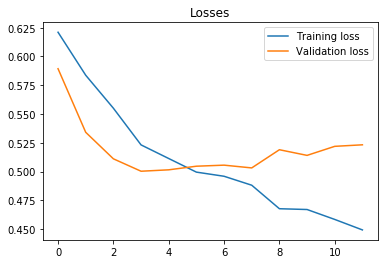

In [34]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title("Losses")

In [0]:
model.eval() # disable dropout for deterministic output
with torch.no_grad(): # deactivate autograd engine to reduce memory usage and speed up computations
    y_preds = []
    batch = 0
    for x_batch, y_batch, batch in generate_batch_data(x_test, y_test, batch_size):
        y_pred = model(x_batch)
        y_preds.extend(y_pred.cpu().numpy().tolist())
    y_preds_np = np.array(y_preds)

In [36]:
y_preds_np

array([[0.65109664],
       [0.22620179],
       [0.99586958],
       ...,
       [0.01546532],
       [0.42542809],
       [0.2569392 ]])

In [0]:
y_test_np = df_test[target_columns].values

In [38]:
y_test_np[5:]

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [39]:
auc_scores = roc_auc_score(y_test_np, y_preds_np, average=None)
df_accuracy = pd.DataFrame({"label": target_columns, "auc": auc_scores})
df_accuracy.sort_values('auc')[::-1]

,label,auc
0,task,0.79567


In [40]:
positive_labels = df_train[target_columns].sum().sum()
positive_labels

2658

In [41]:
all_labels = df_train[target_columns].count().sum()
all_labels

8000

In [42]:
positive_labels/all_labels

0.33225

In [0]:
df_test_targets = df_test[target_columns]
df_pred_targets = pd.DataFrame(y_preds_np.round(), columns=target_columns, dtype=int)
df_sanity = df_test_targets.join(df_pred_targets, how='inner', rsuffix='_pred')

In [44]:
df_sanity

,task,task_pred
0,1,1
1,0,0
2,1,1
3,1,1
4,1,0
...,...,...
2595,0,0
2596,0,0
2597,0,0
2598,0,0


In [45]:
df_test_targets.sum()

task    850
dtype: int64

In [46]:
df_pred_targets.sum()

task    567
dtype: int64

In [47]:
df_sanity[df_sanity.task > 0][['task']]

,task
0,1
2,1
3,1
4,1
5,1
...,...
2583,1
2585,1
2586,1
2591,1
